# 02: Plotting and Interactive Data Analysis

We provide a few plotting tools to interactively explore the TCGA data with the help of sample-specific transcriptional networks.

You can use these tools to look at how different data representations (sample-specific networks, gene expression, or metagene expression) associate with different contextual features and patient groups.
Based on your plots, you can filter to the groups of patients you're interested in and re-plot, then filter again, plot again, etc.
Sample-specific networks capture many different genomic, environmental, and clinical feature interactions in different contexts. Explore for yourself!

Finally, once you've found some interesting groups, you can do a survival analysis to see if these groupings are prognostic.

In [1]:
# Load dependencies
import argparse
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import r_regression
from sklearn.cluster import KMeans, AgglomerativeClustering
from lifelines.statistics import logrank_test, multivariate_logrank_test, pairwise_logrank_test
from lifelines import KaplanMeierFitter
from lifelines.utils import qth_survival_times
import kaplanmeier as km
import umap
from pdf2image import convert_from_path

/opt/homebrew/Caskroom/miniforge/base/envs/pnas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
data_dir = 'data'
networks_file = 'data/networks.csv'

covariate_files = [
    'clinical_covariates.csv',
    'snv_covariates.csv',
    'scna_other_covariates.csv',
    'scna_arm_covariates.csv',
    'scna_gene_covariates.csv',
]
covars = pd.read_csv(os.path.join(data_dir, covariate_files[0]), header=0)
for covariate_file in covariate_files[1:]:
    covars = covars.merge(pd.read_csv(os.path.join(data_dir, covariate_file), header=0), on='sample_id', how='inner')

survival_df = pd.read_csv(os.path.join(data_dir, 'survival.csv'))
gene_expression = pd.read_csv(os.path.join(data_dir, 'transcriptomic_features.csv'))
metagene_expression = pd.read_csv(os.path.join(data_dir, 'metagene_expression.csv'))

networks = pd.read_csv(networks_file).drop(columns='Set')
networks = covars.merge(networks, on='sample_id', how='inner')[networks.columns]
networks = networks.drop(columns=[col for col in networks.columns if len(networks[col].unique()) == 1])

# Load known subtypes
known_subtypes_df = pd.read_csv(os.path.join(data_dir, 'tcga_subtypes_selected.csv'))
covars['TCGA Subtype'] = covars.merge(known_subtypes_df, on='sample_id', how='left')['Subtype_Selected']

# make columns numeric
numeric_covars = [
    'age_at_diagnosis',
    'percent_neutrophil_infiltration',
    'percent_monocyte_infiltration',
    # 'percent_normal_cells',
    # 'percent_tumor_nuclei',
    'percent_lymphocyte_infiltration',
    'percent_stromal_cells',
    # 'percent_tumor_cells',
    'Purity',
    'Ploidy',
    'WGD',
    'stage',
]
numeric_covars += [col for col in covars.columns if 'Mutated' in col or 'Gene' in col or 'Arm' in col or 'Allele' in col]
for col in numeric_covars:
    covars[col] = pd.to_numeric(covars[col], errors='coerce')

# Do a little data cleaning to make the plots nice
# Drop columns with 'X' 'Arm' and 'Loss of Heterozygosity' in the name
drop_x = [col for col in covars.columns if 'X' in col and 'Arm' in col and 'Loss of Heterozygosity' in col]
covars = covars.drop(columns=drop_x)
# Change duplicated to amplified by checking if number of copies is greater than 2 when WGD is true
genes = [col.split(' Gene')[0] for col in covars.columns if 'Gene' in col]
arms = [col.split(' Major Arm')[0] for col in covars.columns if 'Major Arm' in col]
tumor_ploidy = (covars['Ploidy'] - 2 * (1 - covars['Purity'])) / covars['Purity']
gene_amplified_cols = []
for gene in genes:
    n_major_copies = covars[f'{gene} Major Allele Copies']
    n_minor_copies = covars[f'{gene} Minor Allele Copies']
    covars[f'{gene} Major Allele Amplified'] = n_major_copies > tumor_ploidy
    covars[f'{gene} Minor Allele Amplified'] = n_minor_copies > tumor_ploidy
    gene_amplified_cols.append(f'{gene} Major Allele Amplified')
    gene_amplified_cols.append(f'{gene} Minor Allele Amplified')
arm_amplified_cols = []
for arm in arms:
    n_major_copies = covars[f'{arm} Major Arm Copies']
    n_minor_copies = covars[f'{arm} Minor Arm Copies']
    covars[f'{arm} Major Arm Amplified'] = n_major_copies > tumor_ploidy
    covars[f'{arm} Minor Arm Amplified'] = n_minor_copies > tumor_ploidy
    arm_amplified_cols.append(f'{arm} Major Arm Amplified')
    arm_amplified_cols.append(f'{arm} Minor Arm Amplified')
# Drop columns with 'Duplicated' in the name
drop_duplicated = [col for col in covars.columns if 'Duplicated' in col]
covars = covars.drop(columns=drop_duplicated)
# Drop columns with 'Copies' in the name
# drop_copies = [col for col in covars.columns if 'Copies' in col]
# covars = covars.drop(columns=drop_copies)
# Clean up numeric_covars
numeric_covars += gene_amplified_cols + arm_amplified_cols
numeric_covars = [col for col in numeric_covars if col not in drop_x + drop_duplicated]
# Convert age from days to years
covars['age_at_diagnosis'] = covars['age_at_diagnosis'] // 365.25
covars = covars.copy()  # Clean up fragmentation
print('finished dataloading')

# Dry-run
# dryrun_ids = covars[['sample_id', 'submitter_id']][covars['disease_type'].isin(['LGG', 'GBM', 'THCA'])]
# networks = networks[networks['sample_id'].isin(dryrun_ids['sample_id'])]
# covars = covars[covars['sample_id'].isin(dryrun_ids['sample_id'])]
# gene_expression = gene_expression[gene_expression['sample_id'].isin(dryrun_ids['sample_id'])]
# metagene_expression = metagene_expression[metagene_expression['sample_id'].isin(dryrun_ids['sample_id'])]
# survival_df = survival_df[survival_df['submitter_id'].isin(dryrun_ids['submitter_id'])]
# known_subtypes_df = known_subtypes_df[known_subtypes_df['sample_id'].isin(dryrun_ids['sample_id'])]

# We care about these dataframes
# networks, covars, gene_expression, metagene_expression, survival_df, known_subtypes_df


/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_93961/3679373414.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covars[f'{gene} Major Allele Amplified'] = n_major_copies > tumor_ploidy
/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_93961/3679373414.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covars[f'{gene} Minor Allele Amplified'] = n_minor_copies > tumor_ploidy
/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_93961/3679373414.py:58: PerformanceWarning: DataFrame is highly fragmen

finished dataloading


## Plotting Tools

In [3]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering

import plotly.graph_objects as go
import plotly.figure_factory as ff
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from IPython.display import IFrame

import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


def get_rgblist(colors):
    rgblist = []
    for color in colors:
        colorscale = cm.get_cmap(color).colors
        rgblist += [f'rgb({int(c[0] * 255)},{int(c[1] * 255)},{int(c[2] * 255)})' for c in colorscale]
    return rgblist


def color_to_rgblist(color, n):
    """
    Gets the first n items of a categorical colormap,
    or splits a continuous colormap into n uniformly spaced colors
    """
    if n < 2:
        n = 2
    raw_cmap = cm.get_cmap(color)
    if type(raw_cmap) == LinearSegmentedColormap or len(raw_cmap.colors) > 20:
        raw_cmap = raw_cmap.resampled(n)
        clist = [raw_cmap(i)[:3] for i in range(n)]
        raw_cmap = ListedColormap(clist)
    cmap_colors = raw_cmap.colors
    colorscale = cmap_colors[:n]
    new_cmap = ListedColormap(colorscale)
    rgblist = [f'rgb({int(c[0] * 255)},{int(c[1] * 255)},{int(c[2] * 255)})' for c in colorscale]
    return rgblist


def cdist(m):
    """
    Distance function with some rounding errors that runs in O(n^2).
    Necessary for creating dendrograms with 10000+ elements
    """
    xy = np.dot(m, m.T)  # O(k^2)
    x2 = y2 = (m * m).sum(1)  # O(k^2)
    d2 = np.add.outer(x2, y2) - 2 * xy  # O(k^2)
    d2.flat[::len(m) + 1] = 0  # Rounding issues
    d2[d2 < 0] = 0  # More rounding issues with identical samples
    return squareform(np.sqrt(d2))  # O (k^2)


def plot_dendrogram(networks_flat, title='', method='ward', spectrums=[], spectrum_labels=[], spectrum_types=[],
                    colors=[], show_legends=[], savepath=None, dendro_height=100, n_clusters=None):
    heatmap_height = 300  # pixels
    spectrum_height = 20  # pixels
    spectrums_height = len(spectrums) * spectrum_height
    # dendro_height = 100  # pixels
    total_height = heatmap_height + spectrums_height + dendro_height
    total_width = 1400
    heatmap_frac = heatmap_height / total_height
    spectrums_frac = spectrums_height / total_height
    spectrum_frac = spectrums_frac / len(spectrums)
    heatmap_x_frac = 0.6
    cbar_legend_x = 0.72
    cbar_width = 100 / total_width
    cbar_height = 80 / total_height
    legend_x = cbar_legend_x + cbar_width + 0.05
    divider = 0.003

    # row normalize
    row_mins = np.min(networks_flat, axis=0)
    row_maxs = np.max(networks_flat, axis=0)
    row_scale = row_maxs - row_mins
    row_scale[row_scale == 0] = 1
    scaled_data = ((networks_flat - row_mins) / row_scale * 2 - 1)
    data_array = scaled_data
    labels = np.arange(len(data_array)).astype(str)

    def linkagefun(x):
        return linkage(x, method)

    # Initialize figure by creating upper dendrogram (patient similarities)
    fig = ff.create_dendrogram(networks_flat, orientation='bottom', color_threshold=np.Inf, distfun=cdist,
                               linkagefun=linkagefun)  # , labels=labels)
    for i in range(len(fig['data'])):
        fig['data'][i]['yaxis'] = 'y2'
        fig['data'][i]['showlegend'] = False  # needs to be manually turned off when showing other legends

    # Create Side Dendrogram
    dendro_side = ff.create_dendrogram(networks_flat.T, orientation='right', color_threshold=np.Inf, distfun=cdist,
                                       linkagefun=linkagefun)
    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'
        dendro_side['data'][i]['showlegend'] = False  # also needs to be manually turned off

    # Add Side Dendrogram Data to Figure
    #     for data in dendro_side['data']:
    #         fig.add_trace(data)

    # Get dendrogram indices
    dendro_leaves_x = fig['layout']['xaxis']['ticktext']
    dendro_leaves_x = list(map(int, dendro_leaves_x))
    dendro_leaves_y = dendro_side['layout']['yaxis']['ticktext']
    dendro_leaves_y = list(map(int, dendro_leaves_y))

    # Add covariate spectrum bars
    num_colorbars = 0  # do a count because we build legends backwards
    for spectrum_type, show_legend in zip(spectrum_types, show_legends):
        if spectrum_type.lower() == 'continuous' and show_legend:
            num_colorbars += 1
    colorbar_i = 0
    for fig_i, (spectrum, spectrum_label, spectrum_type, color, show_legend) in enumerate(
            zip(spectrums[::-1], spectrum_labels[::-1], spectrum_types[::-1], colors[::-1], show_legends[::-1])):
        spectrum_filtered = spectrum[~pd.isnull(spectrum)]
        #         if '3q' in spectrum_label or 'TP53' in spectrum_label:
        #             plt.figure(figsize=(4, 0.5))
        #             plt.pcolormesh([spectrum, spectrum[dendro_leaves_x]])
        #             plt.show()
        if spectrum_type.lower() == 'continuous':
            colorscale = color
            legend_kwargs = {'showscale': False}
            if show_legend:
                colorbar_title = spectrum_label
                if "-log" in spectrum_label:
                    colorbar_title = colorbar_title.split(" (-log")[0]
                # if "percent" in colorbar_title:
                #     max_val = 100
                #     min_val = 0
                # else:
                max_val = np.max(spectrum_filtered)
                min_val = np.min(spectrum_filtered)
                tickvals = [min_val, (max_val - min_val) / 2 + min_val, max_val]
                # Compress to 2 sig figs. If the values are >1, display as int.
                if 'Purity' in spectrum_label:
                    ticktext = [str(float(f"{min_val:.2f}")), str(float(f"{(max_val - min_val) / 2 + min_val:.2f}")), str(float(f"{max_val:.2f}"))]
                elif max_val < 10:
                    ticktext = [str(float(f"{min_val:.1E}")), str(float(f"{(max_val - min_val) / 2 + min_val:.1E}")), str(float(f"{max_val:.1E}"))]
                else:
                    ticktext = [str(int(float(f"{min_val:.1E}"))), str(int(float(f"{(max_val - min_val) / 2 + min_val:.1E}"))), str(int(float(f"{max_val:.1E}")))]
                # ticktext = [str(int(float(f"{min_val:.1E}"))), str(int(float(f"{(max_val - min_val) / 2 + min_val:.1E}"))), str(int(float(f"{max_val:.1E}")))]
                legend_kwargs.update({
                    'showscale': True,
                    'colorbar_orientation': 'h',
                    'colorbar_xanchor': 'left',
                    'colorbar_x': cbar_legend_x,
                    'colorbar_yanchor': 'top',
                    'colorbar_y': 1.095 - (num_colorbars * cbar_height) + (colorbar_i) * cbar_height,
                    'colorbar_len': cbar_width,
                    'colorbar_thickness': 15,
                    'colorbar_tickvals': tickvals,
                    'colorbar_ticktext': ticktext,
                    'colorbar_tickfont_size': 10,
                    'colorbar_title': dict(text=colorbar_title, side='top'),
                    'colorbar_title_font_size': 13,
                    'zmin': min_val,
                    'zmax': max_val,
                })
                colorbar_i += 1
            oncoplot_fig = go.Figure(data=go.Heatmap(
                x=dendro_leaves_x,
                y=[spectrum_label] * len(dendro_leaves_x),
                z=spectrum[dendro_leaves_x],
                yaxis=f'y{fig_i + 3}',
                xaxis='x',
                colorscale=colorscale,
                **legend_kwargs,
            ))
            # oncoplot_legend = go.Figure(data=go.Heatmap(
            #     z=np.linspace(np.min(spectrum_filtered), np.max(spectrum_filtered), 100)[np.newaxis, :],
            #     colorscale=colorscale,
            #     yaxis=f'y{fig_i + 3}',
            #     xaxis=f'x{fig_i + 3}',
            #     showscale=False,
            # ))
        else:
            def categorical_heatmap_annotation(spectrum, dendro_leaves_x, legendgroup, color, xaxis, yaxis, rank=1000):
                """
                For placement above a main plot, spectrum must be 1D and the title will be on the left.
                Returns a figure with a heatmap on xaxis and yaxis, as well as a legend
                    created using invisible scatter plots on xaxis1000 and yaxis100
                Motivated by heatmaps that only support continuous variables.
                """
                if '-log' in legendgroup:
                    legendgroup_title = legendgroup.split(' (-log')[0]
                else:
                    legendgroup_title = legendgroup
                spectrum_filtered = spectrum[~pd.isnull(spectrum)]
                num_categories = int(len(np.unique(spectrum_filtered)))
                if type(color) == list:
                    rgblist = color
                else:
                    rgblist = color_to_rgblist(color, num_categories)
                if len(rgblist) < 2:  # catch bad colors
                    rgblist = ['rgb(0,0,0)', 'rgb(0,0,0)']
                legend = go.Figure()
                # spectrum_filtered = spectrum_filtered.astype(str)
                for rgb, specval in zip(rgblist, np.unique(spectrum_filtered)):
                    legend.add_trace(
                        go.Scatter(
                            x=[0],
                            y=[0],
                            xaxis='x1000',
                            yaxis='y1000',
                            legendgroup=legendgroup,
                            legendgrouptitle_text=legendgroup_title,
                            legendrank=rank,
                            name=str(specval),
                            mode='markers',
                            # visible='legendonly',  # makes the legends semitransparent, maybe fix if this is an issue?
                            showlegend=True,
                            marker=dict(
                                size=100,
                                color=rgb,
                                symbol='square',
                                line=dict(
                                    width=0,
                                )
                            )
                        )
                    )
                spectrum_vals = np.zeros(len(spectrum))
                for i, specval in enumerate(np.unique(spectrum_filtered)):  # pd retains ordering, np sorts
                    spectrum_vals[spectrum == specval] = i
                spectrum_vals[pd.isnull(spectrum)] = np.nan
                heatmap = go.Figure(
                    go.Heatmap(
                        x=dendro_leaves_x,
                        y=[legendgroup] * len(dendro_leaves_x),
                        z=spectrum_vals[dendro_leaves_x],
                        xaxis=xaxis,
                        yaxis=yaxis,
                        colorscale=rgblist,
                        showscale=False,
                    )
                )
                return heatmap, legend
            oncoplot_fig, oncoplot_legend = categorical_heatmap_annotation(
                spectrum,
                dendro_leaves_x,
                spectrum_label,
                color,
                'x',
                f'y{fig_i + 3}',
                rank=len(spectrums) - fig_i
            )
        for i in range(len(oncoplot_fig['data'])):
            oncoplot_fig['data'][i]['x'] = fig['layout']['xaxis']['tickvals']
        for data in oncoplot_fig['data']:
            fig.add_trace(data)
        if show_legend and spectrum_type != 'continuous':
            # Not showing continuous legends, since plotly groups colorbars and other legends differently
            for data in oncoplot_legend['data']:
                fig.add_trace(data)

    # Generate Heatmap
    heat_data = data_array.T
    heat_data = heat_data[dendro_leaves_y, :]
    heat_data = heat_data[:, dendro_leaves_x]
    heatmap = [
        go.Heatmap(
            x=dendro_leaves_x,
            y=dendro_leaves_y,
            z=heat_data,
            colorscale='RdBu',
            zmid=0,
            #             legendgroup = 'Networks',
            colorbar_orientation='v',
            colorbar_xanchor='left',
            colorbar_x=heatmap_x_frac,
            colorbar_yanchor='bottom',
            colorbar_y=0.0,
            colorbar_len=heatmap_frac,
            # colorbar_thickness=5,
            #             name = 'Networks',
            #             showlegend = True,
        ),
    ]
    heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']
    heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']

    # Add Heatmap Data to Figure
    for data in heatmap:
        fig.add_trace(data)

    # Edit Layout
    fig.update_layout({
        'width': total_width,
        'height': total_height,
        'showlegend': True,
        'hovermode': 'closest',
    })
    # Edit xaxis
    fig.update_layout(xaxis={'domain': [.1, heatmap_x_frac],
                             'mirror': False,
                             'showgrid': False,
                             'showline': False,
                             'zeroline': False,
                             'showticklabels': False,
                             'ticks': ""})
    # Edit xaxis2
    fig.update_layout(xaxis2={'domain': [0, .1],
                              'mirror': False,
                              'showgrid': False,
                              'showline': False,
                              'zeroline': False,
                              'showticklabels': False,
                              'ticks': ""})

    # Edit yaxis
    fig.update_layout(yaxis={'domain': [0, heatmap_frac],
                             'mirror': False,
                             'showgrid': False,
                             'showline': False,
                             'zeroline': False,
                             'showticklabels': False,
                             'ticks': ""
                             })

    # Edit yaxis2
    fig.update_layout(yaxis2={'domain': [heatmap_frac + spectrums_frac + divider * 2, 1.],
                              'mirror': False,
                              'showgrid': False,
                              'showline': False,
                              'zeroline': False,
                              'showticklabels': False,
                              'ticks': ""})

    fig.update_layout(title=title)
    legend_kwargs = {
        'yaxis1000': {
            'domain': [0, 0.001],
            'showgrid': False,
            'showticklabels': False,
            'visible': True,
        },
        'xaxis1000': {
            'domain': [0, 0.001],
            'showgrid': False,
            'showticklabels': False,
            'visible': True,
        },
        'legend': {
            'yanchor': 'top',
            'y': 1.0,
            'xanchor': 'left',
            'x': legend_x,
            'orientation': 'v',
            #         'itemwidth': 30,
            #         'thickness': 30,
        },
    }
    fig.update_layout(**legend_kwargs)

    for i, spectrum_type in enumerate(spectrum_types[::-1]):
        kwargs = {
            f'yaxis{i + 3}': {
                'domain': [heatmap_frac + divider + spectrum_frac * i,
                           heatmap_frac + divider + spectrum_frac * (i + 1)],
                'showgrid': True,
                'showticklabels': True,
            },
        }
        if spectrum_type == 'continuous':
            kwargs.update({
                f'xaxis{i + 3}': {
                    'domain': [0.9, 1.],
                    'showgrid': False,
                    'showticklabels': False,
                },
            })
        fig.update_layout(**kwargs)


    # Infer clusters if requested and add vertical line separators
    if n_clusters is not None and n_clusters > 1:
        method = 'ward'
        criterion = 'maxclust'
        dist_array = cdist(networks_flat)
        Z = linkage(dist_array, method=method)
        cluster_labels = fcluster(Z, n_clusters, criterion=criterion)
        dendrogram_idx = dendrogram(Z, no_plot=True)['leaves']

        # Get relative positions across heatmap for vertical lines
        cluster_positions = []
        curr = None
        for i, cluster_label in enumerate(cluster_labels[dendrogram_idx]):
            if curr is None or cluster_label == curr:
                curr = cluster_label
                continue
            else:
                cluster_positions.append(i / len(cluster_labels))
                curr = cluster_label

        # Draw the vertical lines
        for i, cluster_position in enumerate(cluster_positions):
            axis_num = f'{500 + i:03d}'
            line = go.Scatter(
                        x=[1, 1],
                        y=[-1, 2],
                        xaxis='x' + axis_num,
                        yaxis='y' + axis_num,
                        legendgroup=None,
                        showlegend=False,
                        mode='lines',
                        line=dict(color='black', width=100),
                    )
            fig.add_trace(line)
            xpos = (heatmap_x_frac - 0.1) * cluster_position + 0.1
            fig.update_layout(**{
                # format to 2 digits with leading zero
                'xaxis' + axis_num: {
                    'domain': [xpos, xpos + 0.001],
                    'showgrid': False,
                    'showline': False,
                    'zeroline': False,
                    'showticklabels': False,
                    'visible': False,
                },
                'yaxis' + axis_num: {
                    'domain': [0., heatmap_frac + spectrums_frac + divider],
                    'showgrid': False,
                    'showline': False,
                    'zeroline': False,
                    'showticklabels': False,
                    'visible': False,
                    'range': [0, 1],
                },
                # 'paper_bgcolor': 'rgba(0,0,0,0)',
                # 'plot_bgcolor': 'rgba(0,0,0,0)',
            })
    return fig


def display_bigfig(fig):
    fig.write_image('bigfig.pdf', scale=1.)
    return IFrame('bigfig.pdf', width=1000, height=1000)

In [4]:
data_views = {
    'biopsy': [
        'percent_neutrophil_infiltration',
        'percent_monocyte_infiltration',
        # 'percent_normal_cells',
        # 'percent_tumor_nuclei',
        'percent_lymphocyte_infiltration',
        'percent_stromal_cells',
        # 'percent_tumor_cells',
    ],
    'arm-level scna': [col for col in covars.columns if 'Arm' in col and 'Copies' not in col] + ['WGD'],
    'gene-level scna': [col for col in covars.columns if ('Gene' in col or 'Allele' in col) and ('Copies' not in col)],
    'snv': [col for col in covars.columns if 'Mutated' in col],
}
view_rev_lookup = {v_i: k for k, v in data_views.items() for v_i in v}

def annotated_heatmap(sample_ids, which_data='networks', annotation_features=['disease_type', 'primary_site', 'sample_type']):
    """
    Args:
        show_data (str): networks, gene_expression, or metagene_expression
    """
    feature_colors = {
        'disease_type': get_rgblist(['tab20b', 'tab20c']),
        'primary_site': get_rgblist(['tab20']),
        'sample_type': 'Blues',
        'biopsy': 'Purples',
        'arm-level scna': 'Greens',
        'gene-level scna': 'Blues',
        'snv': 'Reds',
        'my_subtype': 'tab20b',
        'Subtype_Selected': 'tab20',
        'race': 'rainbow',
        'sex': 'cool_r',
        'age_at_diagnosis': 'Greys',
        'stage': 'Reds',
        'purity': 'Purples',
        'ploidy': 'Purples',
    }

    feature_types = {
        'disease_type': 'categorical',
        'primary_site': 'categorical',
        'sample_type': 'categorical',
        'biopsy': 'continuous',
        'arm-level scna': 'continuous',
        'gene-level scna': 'continuous',
        'snv': 'continuous',
        'my_subtype': 'categorical',
        'Subtype_Selected': 'categorical',
        'race': 'categorical',
        'sex': 'categorical',
        'age_at_diagnosis': 'continuous',
        'stage': 'categorical',
        'purity': 'continuous',
        'ploidy': 'continuous',
    }

    # plot these samples, show these features above the heatmap.
    # Todo: cluster samples
    if which_data == 'networks':
        data = networks
    elif which_data == 'gene_expression':
        data = gene_expression
    elif which_data == 'metagene_expression':
        data = metagene_expression

    plot_df = covars.merge(data, on='sample_id', how='inner')
    plot_df = plot_df[plot_df['sample_id'].isin(sample_ids)]

    spectrums = []
    spectrum_labels = []
    spectrum_types = []
    colors = []
    for feature in annotation_features:
        spectrum = plot_df[feature].values
        spectrum_label = feature
        if feature in view_rev_lookup:
            feature_name = feature
            feature = view_rev_lookup[feature]
        spectrum_type = feature_types[feature]
        if type(feature_colors[feature]) == str:
            color = feature_colors[feature]
        else:
            color = feature_colors[feature][:len(np.unique(spectrum))]
        spectrums.append(spectrum)
        spectrum_labels.append(spectrum_label)
        spectrum_types.append(spectrum_type)
        colors.append(color)
    show_legends = [True] * len(annotation_features)

    return plot_dendrogram(
        plot_df[data.columns].drop(columns=['sample_id']).values,
        title=f'Patients Organized by {which_data}',
        method='ward',
        spectrums=spectrums,
        spectrum_labels=spectrum_labels,
        spectrum_types=spectrum_types,
        colors=colors,
        show_legends=show_legends,
    )


def annotated_heatmap_with_clusters(sample_ids, which_data='networks', num_clusters=None, subtype_prefix='my_subtype'):
    if which_data == 'networks':
        subtyping_data = networks
    elif which_data == 'gene_expression':
        subtyping_data = gene_expression
    elif which_data == 'metagene_expression':
        subtyping_data = metagene_expression

    # Only process samples in subtyping_data
    my_covars = covars.merge(subtyping_data[['sample_id']], on='sample_id', how='inner')[covars.columns].copy()
    my_covars.reset_index(drop=True, inplace=True)
    subtyping_data.reset_index(drop=True, inplace=True)

    # multi-disease
    disease_idx = my_covars['sample_id'].isin(sample_ids)
    disease_covars = my_covars[disease_idx]

    # Remove redundant features due to higher-level alterations (favor WGD over arm over gene)
    max_feature_overlap = 0.7
    redundant_features = set()
    for arm_col in data_views['arm-level scna']:
        for gene_col in data_views['gene-level scna']:
            x = disease_covars[arm_col].values[:, np.newaxis]
            y = disease_covars[gene_col].values
            corr = r_regression(x, y)
            if corr > max_feature_overlap:
                redundant_features.add(gene_col)
    x = disease_covars['WGD'].values[:, np.newaxis]
    for arm_col in data_views['arm-level scna']:
        y = disease_covars[arm_col].values
        corr = r_regression(x, y)
        if corr > max_feature_overlap:
            redundant_features.add(arm_col)

    # Get known subtype labels
    known_subtype_labels = disease_covars.merge(known_subtypes_df, on='sample_id', how='left')['Subtype_Selected']
    unique_subtypes = disease_covars['TCGA Subtype'][~pd.isnull(disease_covars['TCGA Subtype'])].unique()
    num_known_subtypes = len(unique_subtypes)
    print('known subtypes', unique_subtypes, num_known_subtypes)

    # cluster networks and associte features with dendrogram splits
    method = 'ward'
    criterion = 'maxclust'
    network_samples = subtyping_data.drop(columns='sample_id')[disease_idx].values

    dist_array = cdist(network_samples)
    Z = linkage(dist_array, method=method)
    if num_clusters is None:
        k = num_known_subtypes  # get as many network subtypes as known subtypes
    else:
        k = num_clusters
    score = -1
    if num_known_subtypes < 2:
        for n_clusters in range(2, 10):
            subtypes = fcluster(Z, n_clusters, criterion=criterion)
            new_score = silhouette_score(squareform(dist_array), metric='precomputed', labels=subtypes)
            if new_score > score:
                score = new_score
                k = n_clusters
    subtypes = fcluster(Z, k, criterion=criterion)
    subtypes_idx = dendrogram(Z, no_plot=True)['leaves']
    # Increment by order of appearance
    subtype_names = {}
    for subtype in subtypes[subtypes_idx]:
        if subtype not in subtype_names:
            subtype_names[subtype] = f"{subtype_prefix}.{len(subtype_names) + 1}"
    subtypes = np.array([subtype_names[subtype] for subtype in subtypes])
    score = silhouette_score(squareform(dist_array), metric='precomputed', labels=subtypes)
    disease_covars['Network Subtype'] = subtypes
    print('silhouette score', score)

    def get_pval(col):
        if col in redundant_features:
            return 1
        # Check if the column contains strings
        col_samples = disease_covars[col].values
        nan_idx = pd.isnull(col_samples)
        col_samples = col_samples[~nan_idx]
        col_subtypes = subtypes[~nan_idx]
        best_pval = 1
        if disease_covars[col].dtype == 'object':
            for subtype in np.unique(col_subtypes):
                for col_val in pd.unique(col_samples):
                    subtype_idx = col_subtypes == subtype
                    col_onehot = (col_samples == col_val).astype(int)
                    null_set = col_onehot[~subtype_idx]
                    test_set = col_onehot[subtype_idx]
                    _, pval = ttest_ind(test_set, null_set)
                    if np.isnan(pval):
                        pval = 1
                    if pval < best_pval:
                        best_pval = pval
        else:
            for subtype in np.unique(col_subtypes):
                subtype_idx = col_subtypes == subtype
                null_set = col_samples[~subtype_idx]
                test_set = col_samples[subtype_idx]
                _, pval = ttest_ind(test_set, null_set)
                if np.isnan(pval):
                    pval = 1
                if pval < best_pval:
                    best_pval = pval
        return best_pval
    column_pvals = {col: get_pval(col) for col in numeric_covars}
    column_pvals.update({
        'race': get_pval('race'),
        'gender': get_pval('gender'),
    })

    # column_pvals = {col: 1 for col in numeric_covars}
    # for subtype in np.unique(subtypes):
    #     subtype_idx = subtypes == subtype
    #     for col in numeric_covars:
    #         if col in redundant_features:
    #             continue
    #         col_samples = disease_covars[col].values
    #         nan_idx = pd.isnull(col_samples)
    #         col_samples = col_samples[~nan_idx]
    #         col_subtype_idx = subtype_idx[~nan_idx]
    #         null_set = col_samples[~col_subtype_idx]
    #         test_set = col_samples[col_subtype_idx]
    #         _, pval = ttest_ind(test_set, null_set)
    #         if np.isnan(pval):
    #             pval = 1
    #         if pval < column_pvals[col]:
    #             column_pvals[col] = pval
    # sex_pval = 1.0
    # for subtype in np.nique

    max_view_features = 10
    max_feature_pval = 1e-4
    col_labels = []
    col_samples = []
    col_colors = []
    col_types = []
    col_legends = []
    pval_column = lambda col: f"{col} (-log(p) = {round(-np.log10(column_pvals[col]), 1)})" if col in column_pvals else col
    for (data_view, view_cols), color in zip(data_views.items(), ['Purples', 'Greens', 'Blues', 'Reds', 'Oranges']):
        view_pvals = np.array([column_pvals[col] for col in view_cols])
        view_idx = np.argsort(view_pvals)[:max_view_features]
        view_idx = view_idx[view_pvals[view_idx] < max_feature_pval]
        view_names = np.array(view_cols)[view_idx].tolist()
        view_pvals = view_pvals[view_idx].tolist()
        # view_labels = [f"{col} (-log(p) = {round(-np.log10(pval), 1)})" for col, pval in zip(view_names, view_pvals)]
        view_labels = [pval_column(col) for col in view_names]
        col_labels += view_labels
        col_samples += [disease_covars[col].values for col in view_names]
        col_colors += [color] * len(view_labels)
        if data_view == 'biopsy':
            col_types += ['continuous'] * len(view_labels)
            col_legends += [True] * len(view_labels)
        else:
            col_types += ['categorical'] * len(view_labels)
            col_legends += [False] * len(view_labels)
    # col_types = ['continuous'] * len(col_labels)
    # col_legends = [False] * len(col_labels)
#     print(list(zip(col_names, col_pvals, col_colors)))

    # add mandatory features to plot and concatenate
    always_names = ['Network Subtype', 'TCGA Subtype', 'disease_type', 'race', 'gender', 'age_at_diagnosis', 'stage', 'Purity', 'Ploidy']
    # for name in always_names:
    #     if name in column_pvals:
    #         always_pvals.append(column_pvals[col])
    #     else:
    #         always_pvals.append(1)
    always_titles = [pval_column(col) for col in always_names]
    title_labels = ['Network Subtype', 'TCGA Subtype', 'Disease Type', 'Race', 'Sex', 'Age at Diagnosis', 'Stage', 'Purity', 'Ploidy']
    always_labels = [title.replace(col, label) for col, title, label in zip(always_names, always_titles, title_labels)]
    # always_labels = [f"{title} (-log(p) = {round(-np.log10(pval), 1)})" if pval < 1 else title for title, pval in zip(always_titles, always_pvals)]
    always_colors = ['tab20b', 'tab20', 'Pastel1', 'rainbow', 'cool_r', 'Greys', 'Reds', 'Purples', 'Purples']
    always_samples = [disease_covars[col].values for col in always_names]
    always_types = ['categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'continuous', 'categorical', 'continuous', 'continuous']
    always_legends = [True] * len(always_names)

    all_labels = always_labels + col_labels
    all_samples = always_samples + col_samples
    all_colors = always_colors + col_colors
    all_types = always_types + col_types
    all_legends = always_legends + col_legends

    # Remove boring features
    oncoplot_labels, oncoplot_samples, oncoplot_colors, oncoplot_types, oncoplot_legends = [], [], [], [], []
    for i in range(len(all_samples)):
        if len(pd.unique(all_samples[i])) > 1:
            oncoplot_labels.append(all_labels[i])
            oncoplot_samples.append(all_samples[i])
            oncoplot_colors.append(all_colors[i])
            oncoplot_types.append(all_types[i])
            oncoplot_legends.append(all_legends[i])

    # Get disease survival data
    disease_covars['my_subtype'] = subtypes.astype(str)
    print(np.unique(subtypes))
    disease_subtypes = disease_covars[['sample_id', 'disease_type', 'my_subtype']]

    fig = plot_dendrogram(
        network_samples,
        title=f'Patients Organized by {which_data} with {int(k)} Clusters',
        method=method,
        spectrums=oncoplot_samples,
        spectrum_labels=oncoplot_labels,
        spectrum_types=oncoplot_types,
        colors=oncoplot_colors,
        show_legends=oncoplot_legends,
        n_clusters=k,
    )
    return fig, disease_subtypes

## Interactive Data Analysis

In [5]:
# First, let's get a global view of the networks and plot all 25 tumor types with tissue types and healthy/disease samples
# Note: this takes about a minute with all 8k samples. Go make a cup of coffee.
my_sample_ids = covars['sample_id'].values
fig = annotated_heatmap(
    my_sample_ids, # a list or array of sample ids to consider
    which_data='networks', # networks, gene_expression, or metagene_expression
    annotation_features = ['disease_type', 'primary_site', 'sample_type']
)

In [6]:
# This figure is too big to display interactively, so just save it as PDF and display
fig.write_image('bigfig.pdf', scale=1.)

In [7]:
# Cool, looks like the two brain cancers LGG and GBM cluster together. Let's zoom in on those.
my_sample_ids = covars[covars['disease_type'].isin(['LGG', 'GBM'])]['sample_id'].values
fig = annotated_heatmap(
    my_sample_ids,
    which_data='networks',
    annotation_features = ['disease_type', 'primary_site', 'sample_type']
)

In [ ]:
# This plot is interactive. Select a region to zoom in.
display(fig)

In [34]:
# Looks like there's some strong separation, but also some clear organization within LGG.
# Let's plot with 4 clusters and feature annotations for those clusters
fig, subtype_clusters = annotated_heatmap_with_clusters(
    my_sample_ids,
    which_data='networks',
    num_clusters=4,
    subtype_prefix='my_subtype'
)

known subtypes ['THCA.1' 'THCA.3' 'THCA.5' 'THCA.2' 'THCA.4'] 5
silhouette score 0.40977436199192663


/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_83686/2997936730.py:200: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



['LGG.Net.1' 'LGG.Net.2' 'LGG.Net.3' 'LGG.Net.4']


In [ ]:
# This plot is interactive. Select a region to zoom in.
display(fig)

In [12]:
display(subtype_clusters)

,sample_id,disease_type,my_subtype
804,TCGA-02-2483-01A,GBM,my_subtype.4
873,TCGA-06-5412-01A,GBM,my_subtype.4
874,TCGA-28-5204-01A,GBM,my_subtype.4
917,TCGA-19-1390-01A,GBM,my_subtype.4
922,TCGA-06-0747-01A,GBM,my_subtype.4
...,...,...,...
7154,TCGA-DU-6402-01A,LGG,my_subtype.3
7155,TCGA-EZ-7264-01A,LGG,my_subtype.1
7158,TCGA-FG-6689-01A,LGG,my_subtype.2
7162,TCGA-RY-A83Y-01A,LGG,my_subtype.1


In [13]:
# To compare against TCGA's official cancer subtypes, set num_clusters to None
# The plot will automatically match the number of known TCGA subtypes
# If there are none, it will try a few clusterings and take the one with the best silhouette score
fig, my_subtypes = annotated_heatmap_with_clusters(
    my_sample_ids,
    which_data='networks',
    num_clusters=None  # Match the number of TCGA subtypes (or if none exist, choose based on silhouette score)
)

known subtypes ['GBM_LGG.G-CIMP-low' 'GBM_LGG.Mesenchymal-like' 'GBM_LGG.Classic-like'
 'GBM_LGG.Codel' 'GBM_LGG.G-CIMP-high' 'GBM_LGG.PA-like'
 'GBM_LGG.LGm6-GBM'] 7
silhouette score 0.38468913638399493


/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_83686/2522466805.py:200: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/opt/homebrew/Caskroom/miniforge/base/envs/pnas/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning:

divide by zero encountered in divide

/opt/homebrew/Caskroom/miniforge/base/envs/pnas/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning:

invalid value encountered in scalar multiply

/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_83686/2522466805.py:239: RuntimeWarning:

divide by zero encountered in log10



['my_subtype.1' 'my_subtype.2' 'my_subtype.3' 'my_subtype.4'
 'my_subtype.5' 'my_subtype.6' 'my_subtype.7']


In [ ]:
# This plot is interactive. Select a region to zoom in.
display(fig)

## Survival Analysis

Now that we have an interesting grouping, let's see if they have any prognostic power and compare to known subtypes.

In [6]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

def plot_survival(subtype_df, subtype_col='my_subtype', colors='tab20'):
    cmap = cm.get_cmap(colors)
    plot_df = subtype_df.copy()
    plot_df['submitter_id'] = [sample_id[:12] for sample_id in plot_df['sample_id']]
    disease_survival_df = plot_df.merge(survival_df, on='submitter_id', how='inner')
    disease_survival_df.fillna('NA', inplace=True)

    if len(disease_survival_df) == 0:
            return np.nan, np.nan

    multivariate_result = multivariate_logrank_test(disease_survival_df['time'].astype(float), disease_survival_df[subtype_col], disease_survival_df['died'])
    multivariate_pval = multivariate_result.p_value

    results = km.fit(disease_survival_df['time'], disease_survival_df['died'], disease_survival_df[subtype_col])#  != idx_df[label_col].values[0])
    colors = cmap.colors[:len(disease_survival_df[subtype_col].unique())]
    km.plot(results, title=f'{subtype_col} Survival Function\np-value {multivariate_result.p_value}', cmap=colors)
    plt.ylim(-0.05, 1.05)
    # plt.show()

    # Select only the subtypes with the strongest split
    pairwise_result = pairwise_logrank_test(disease_survival_df['time'].astype(float), disease_survival_df[subtype_col], disease_survival_df['died'])
    pairwise_tests = pairwise_result.summary.reset_index()
    best_row = pairwise_tests.iloc[pairwise_tests['p'].values.argmin()]
    best_subtype, worst_subtype, pairwise_min_pval = best_row[['level_0', 'level_1', 'p']]
    print('Multivariate log-rank p-value', multivariate_pval)
    print('Subtypes', best_subtype, 'and', worst_subtype, ' are the most stratified, with a minimum pairwise p-value of', pairwise_min_pval)

    encoded_df = pd.get_dummies(disease_survival_df, columns=[subtype_col], drop_first=False)
    cox_df = encoded_df.drop(columns=['sample_id', 'disease_type', 'submitter_id'])
    cox_df = cox_df.astype(float)
    cph = CoxPHFitter(l1_ratio=0.0, penalizer=0.05)
    cph.fit(cox_df, duration_col='time', event_col='died')
    cph.print_summary()

    model_df = cph.summary
    new_index = [col.replace(subtype_col + "_", '') for col in model_df.index]
    model_df.index = new_index
    model_df = model_df.loc[new_index[::-1]]
    hazard_ratios = model_df['exp(coef)']
    ci_lower = model_df['exp(coef) lower 95%']
    ci_upper = model_df['exp(coef) upper 95%']
    variables = model_df.index
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.errorbar(hazard_ratios, variables, xerr=[hazard_ratios - ci_lower, ci_upper - hazard_ratios],
                fmt='o', color='black', ecolor='blue', capsize=5)
    ax.axvline(1, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel("Hazard Ratio (HR), 95% CI")
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig('../')
    plt.tight_layout()
    plt.show()

Multivariate log-rank p-value 0.006352856524527208
Subtypes THCA.Net.1 and THCA.Net.4  are the most stratified, with a minimum pairwise p-value of 0.0003746225813077533


<lifelines.CoxPHFitter: fitted with 447 total observations, 431 right-censored observations>
             duration col = 'time'
                event col = 'died'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 447
number of events observed = 16
   partial log-likelihood = -82.47
         time fit was run = 2025-02-03 15:22:45 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
my_subtype_THCA.Net.1  1.23      3.41      0.77           -0.29            2.74                0.75               15.55
my_subtype_THCA.Net.2 -0.28      0.76      0.60           -1.46            0.91                0.23                2.47
my_subtype_THCA.Net.3 -0.48      0.62      0.92           -2.28            1.31                0.10                3.70
my_subtype_THCA.Net.4 -0.36      0.70      0.36           -1.06            0.35                0.35                1.41
my_subtype_THCA.Net.5  0.40      1.49      0.35           -0.29            1.09                0.75                2.98

                       cmp to     z    p  -log2(p)
covariate                                         
my_subtype_THCA.Net.1    0.00  1.58 0.11      3.14
my_subtype_THCA.Net.2    0.00 -0.46 0.64      0.63
my_subtype_THCA.Net.3    0.00 -0.53 0.60      0.75
my_subtype_THCA.Net.4    0.00 -1.00 0.32      1.65
my_subtype_THCA.Net.5    0.00  1.14 0.25      1.97
---
Concordance = 0.74
Partial AIC = 174.95
log-likelihood ratio test = 6.16 on 5 df
-log2(p) of ll-ratio test = 1.78

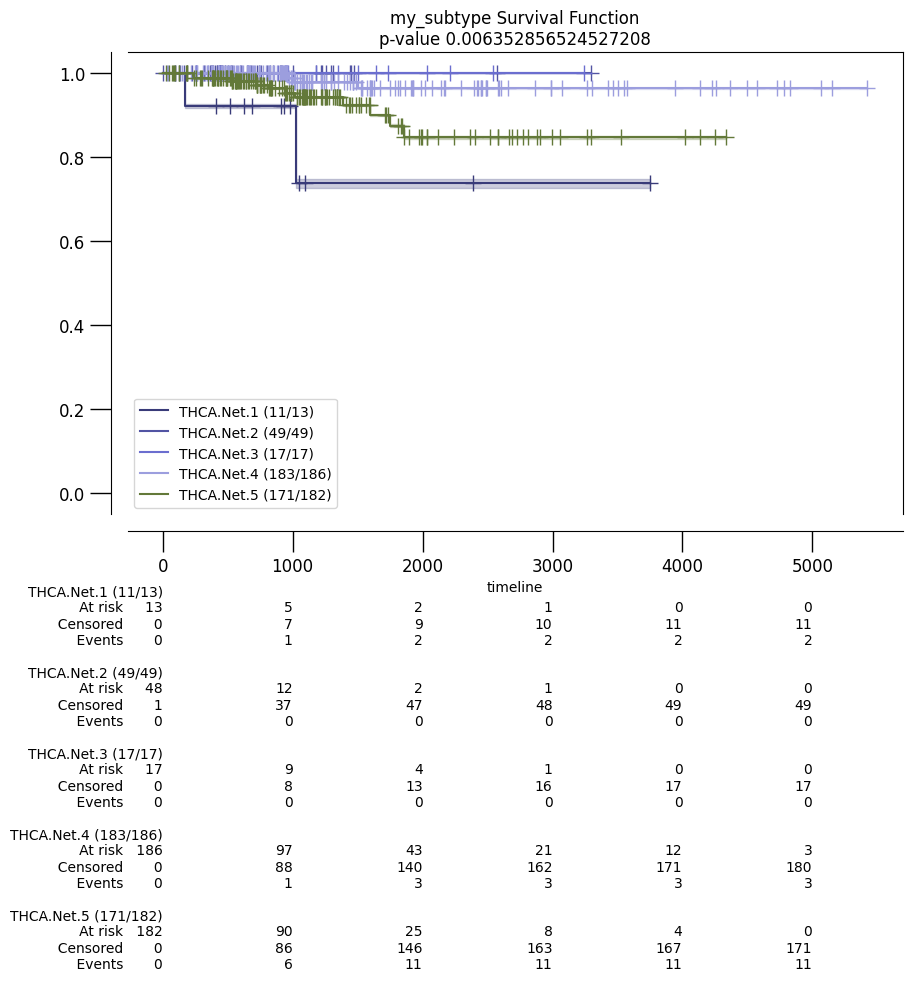

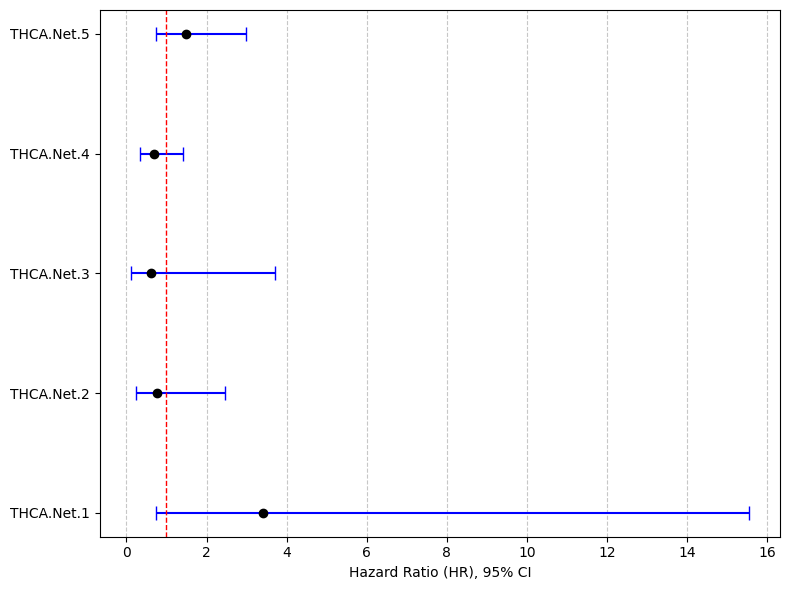

In [48]:
plot_survival(my_subtypes, subtype_col='my_subtype', colors='tab20b')

Multivariate log-rank p-value 1.2645860477231308e-79
Subtypes my_subtype.2 and my_subtype.5  are the most stratified, with a minimum pairwise p-value of 1.403291934478035e-53


<lifelines.CoxPHFitter: fitted with 557 total observations, 379 right-censored observations>
             duration col = 'time'
                event col = 'died'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 557
number of events observed = 178
   partial log-likelihood = -829.39
         time fit was run = 2025-02-03 15:04:45 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
my_subtype_my_subtype.1 -1.04      0.35      0.27           -1.56           -0.52                0.21                0.60
my_subtype_my_subtype.2 -0.79      0.45      0.25           -1.29           -0.30                0.28                0.74
my_subtype_my_subtype.3  0.03      1.04      0.37           -0.69            0.76                0.50                2.14
my_subtype_my_subtype.4  1.41      4.09      0.28            0.86            1.96                2.35                7.12
my_subtype_my_subtype.5  1.98      7.21      0.27            1.45            2.50                4.25               12.24
my_subtype_my_subtype.6  0.63      1.88      0.73           -0.80            2.06                0.45                7.86
my_subtype_my_subtype.7  1.36      3.91      0.42            0.54            2.19                1.71                8.96

                         cmp to     z      p  -log2(p)
covariate                                             
my_subtype_my_subtype.1    0.00 -3.90 <0.005     13.36
my_subtype_my_subtype.2    0.00 -3.17 <0.005      9.34
my_subtype_my_subtype.3    0.00  0.09   0.92      0.11
my_subtype_my_subtype.4    0.00  4.99 <0.005     20.66
my_subtype_my_subtype.5    0.00  7.32 <0.005     41.86
my_subtype_my_subtype.6    0.00  0.86   0.39      1.36
my_subtype_my_subtype.7    0.00  3.23 <0.005      9.66
---
Concordance = 0.82
Partial AIC = 1672.78
log-likelihood ratio test = 230.48 on 7 df
-log2(p) of ll-ratio test = 150.84

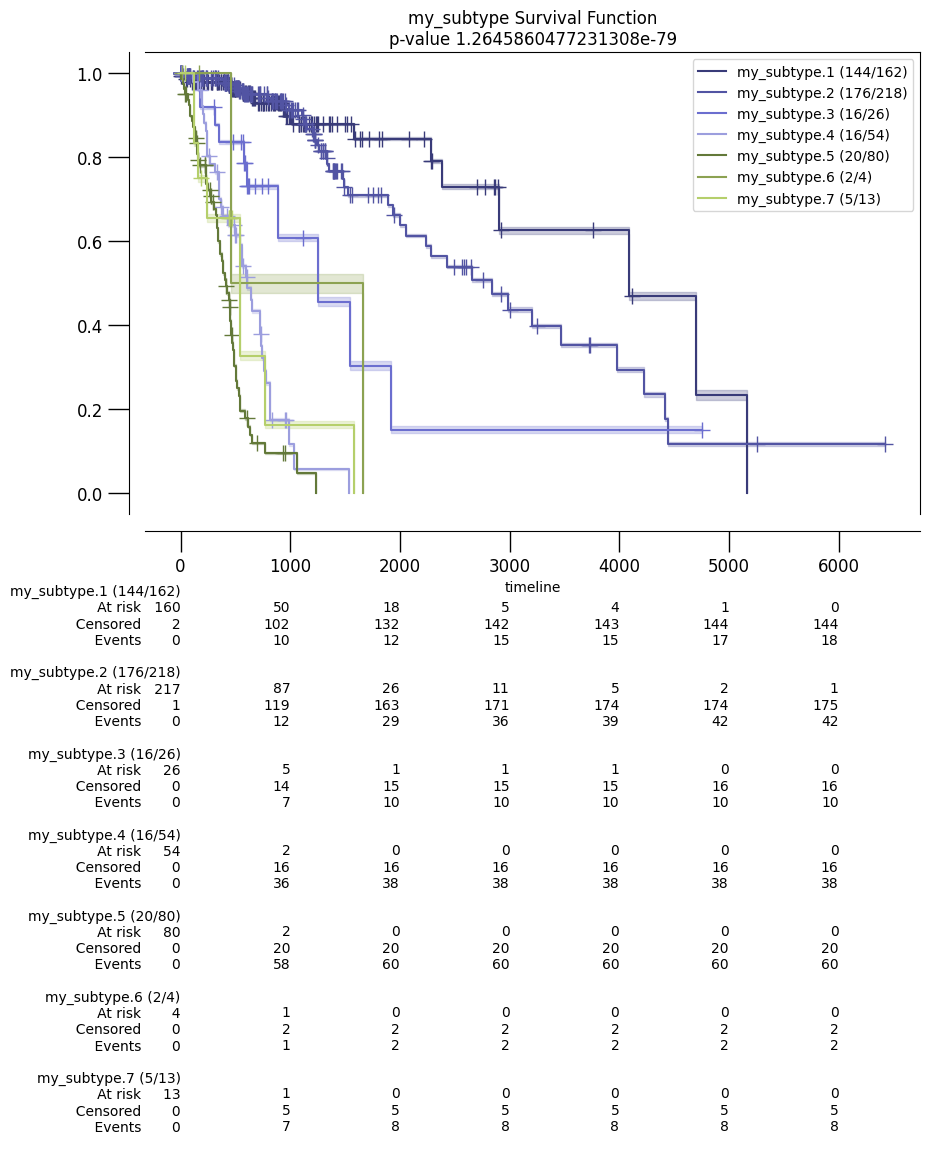

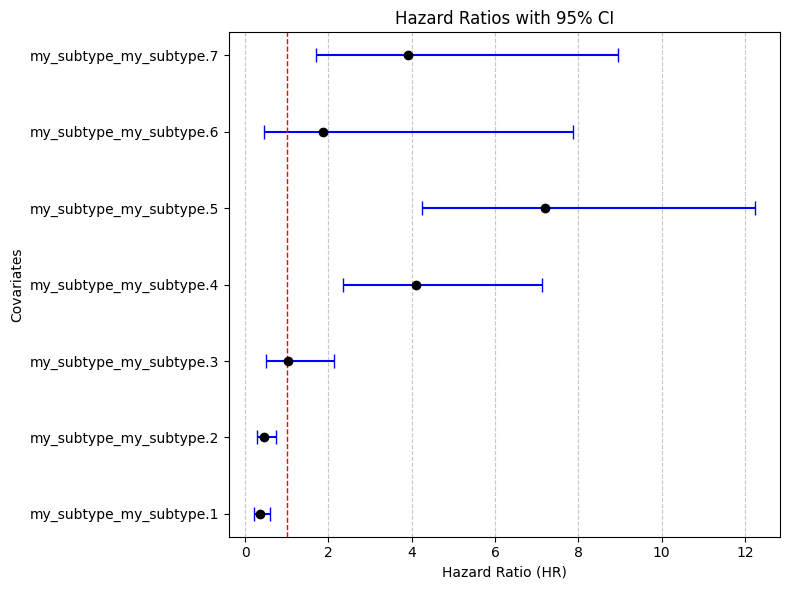

Multivariate log-rank p-value 7.808451093552174e-78
Subtypes GBM_LGG.G-CIMP-high and GBM_LGG.Mesenchymal-like  are the most stratified, with a minimum pairwise p-value of 4.805966693908969e-49


<lifelines.CoxPHFitter: fitted with 557 total observations, 379 right-censored observations>
             duration col = 'time'
                event col = 'died'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 557
number of events observed = 178
   partial log-likelihood = -827.89
         time fit was run = 2025-02-03 15:04:46 UTC

---
                                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                  
Subtype_Selected_GBM_LGG.Classic-like      1.63      5.08      0.28            1.08            2.17                2.95                8.75
Subtype_Selected_GBM_LGG.Codel            -1.05      0.35      0.27           -1.57           -0.53                0.21                0.59
Subtype_Selected_GBM_LGG.G-CIMP-high      -0.81      0.45      0.25           -1.30           -0.32                0.27                0.73
Subtype_Selected_GBM_LGG.G-CIMP-low        1.02      2.78      0.42            0.20            1.84                1.22                6.30
Subtype_Selected_GBM_LGG.LGm6-GBM          2.22      9.19      0.49            1.26            3.18                3.53               23.93
Subtype_Selected_GBM_LGG.Mesenchymal-like  1.72      5.60      0.27            1.20            2.25                3.32                9.45
Subtype_Selected_GBM_LGG.PA-like          -0.67      0.51      0.46           -1.58            0.24                0.21                1.27

                                           cmp to     z      p  -log2(p)
covariate                                                               
Subtype_Selected_GBM_LGG.Classic-like        0.00  5.86 <0.005     27.66
Subtype_Selected_GBM_LGG.Codel               0.00 -3.97 <0.005     13.74
Subtype_Selected_GBM_LGG.G-CIMP-high         0.00 -3.22 <0.005      9.61
Subtype_Selected_GBM_LGG.G-CIMP-low          0.00  2.44   0.01      6.10
Subtype_Selected_GBM_LGG.LGm6-GBM            0.00  4.55 <0.005     17.48
Subtype_Selected_GBM_LGG.Mesenchymal-like    0.00  6.46 <0.005     33.17
Subtype_Selected_GBM_LGG.PA-like             0.00 -1.45   0.15      2.77
---
Concordance = 0.82
Partial AIC = 1669.79
log-likelihood ratio test = 233.48 on 7 df
-log2(p) of ll-ratio test = 152.95

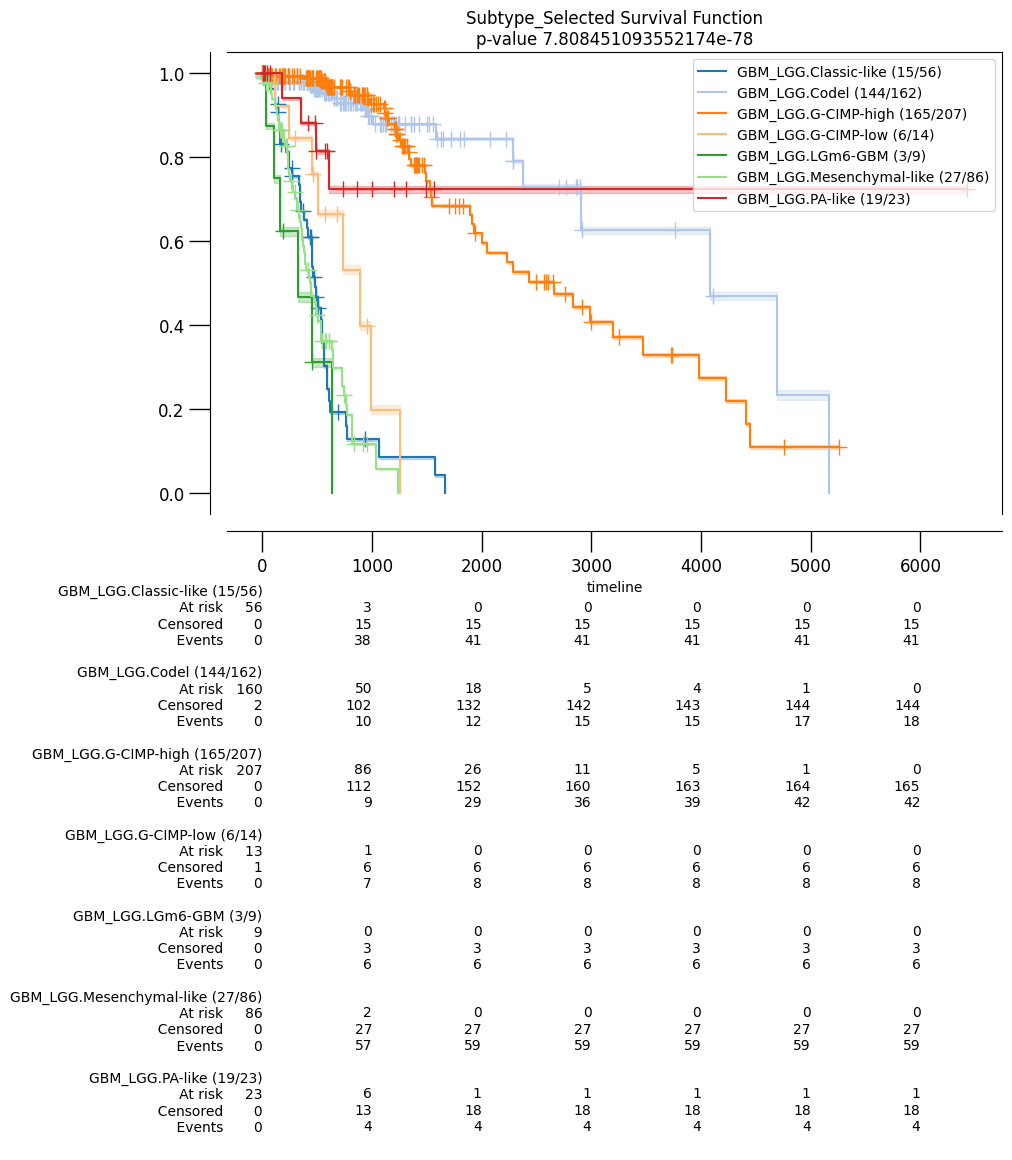

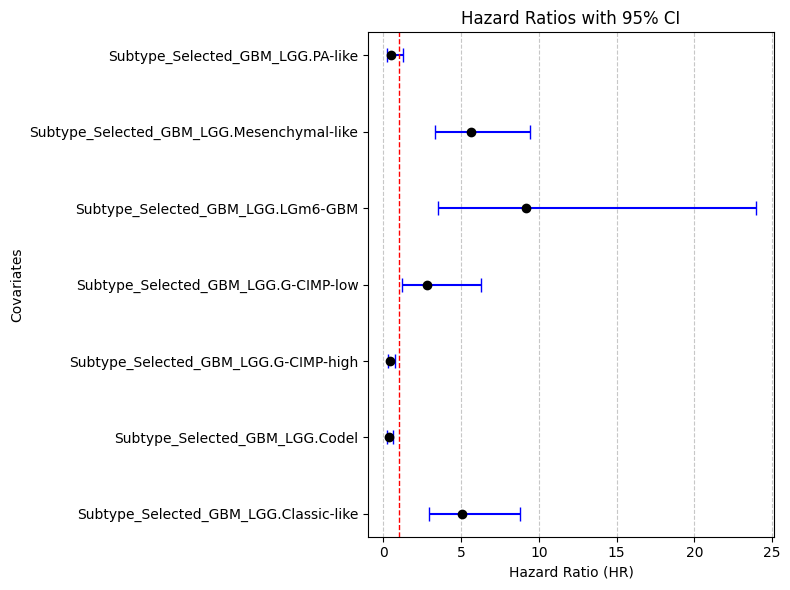

In [31]:
# Looks good, let's filter to only the samples that also have a subtype in TCGA to make a fair comparison with the baseline
my_filtered_subtypes = my_subtypes[my_subtypes['sample_id'].isin(known_subtypes_df['sample_id'])]
tcga_filtered_subtypes = known_subtypes_df[known_subtypes_df['sample_id'].isin(my_subtypes['sample_id'])]
plot_survival(my_filtered_subtypes, subtype_col='my_subtype', colors='tab20b')
plot_survival(tcga_filtered_subtypes, subtype_col='Subtype_Selected', colors='tab20')

# THCA Main Figure + Subtypes

In [ ]:
my_sample_ids = covars[(covars['sample_type'] == 'Primary Tumor') & (covars['disease_type'].isin(['THCA']))]['sample_id'].values
fig, my_subtypes = annotated_heatmap_with_clusters(
    my_sample_ids,
    which_data='networks',
    num_clusters=None,  # match the number of tcga subtypes (or if none exist, choose based on silhouette score)
    subtype_prefix='THCA.Net'
)
fig

Multivariate log-rank p-value 0.007873347444784505
Subtypes THCA.Net.1 and THCA.Net.4  are the most stratified, with a minimum pairwise p-value of 0.0005727886751385115


<lifelines.CoxPHFitter: fitted with 427 total observations, 411 right-censored observations>
             duration col = 'time'
                event col = 'died'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 427
number of events observed = 16
   partial log-likelihood = -81.79
         time fit was run = 2025-02-03 19:33:12 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
my_subtype_THCA.Net.1  1.20      3.32      0.77           -0.32            2.72                0.73               15.12
my_subtype_THCA.Net.2 -0.28      0.75      0.61           -1.48            0.91                0.23                2.50
my_subtype_THCA.Net.3 -0.52      0.60      0.93           -2.35            1.31                0.10                3.71
my_subtype_THCA.Net.4 -0.36      0.70      0.37           -1.07            0.36                0.34                1.43
my_subtype_THCA.Net.5  0.41      1.51      0.36           -0.29            1.11                0.74                3.05

                       cmp to     z    p  -log2(p)
covariate                                         
my_subtype_THCA.Net.1    0.00  1.55 0.12      3.05
my_subtype_THCA.Net.2    0.00 -0.46 0.64      0.63
my_subtype_THCA.Net.3    0.00 -0.55 0.58      0.79
my_subtype_THCA.Net.4    0.00 -0.98 0.33      1.62
my_subtype_THCA.Net.5    0.00  1.14 0.25      1.98
---
Concordance = 0.74
Partial AIC = 173.58
log-likelihood ratio test = 6.14 on 5 df
-log2(p) of ll-ratio test = 1.77

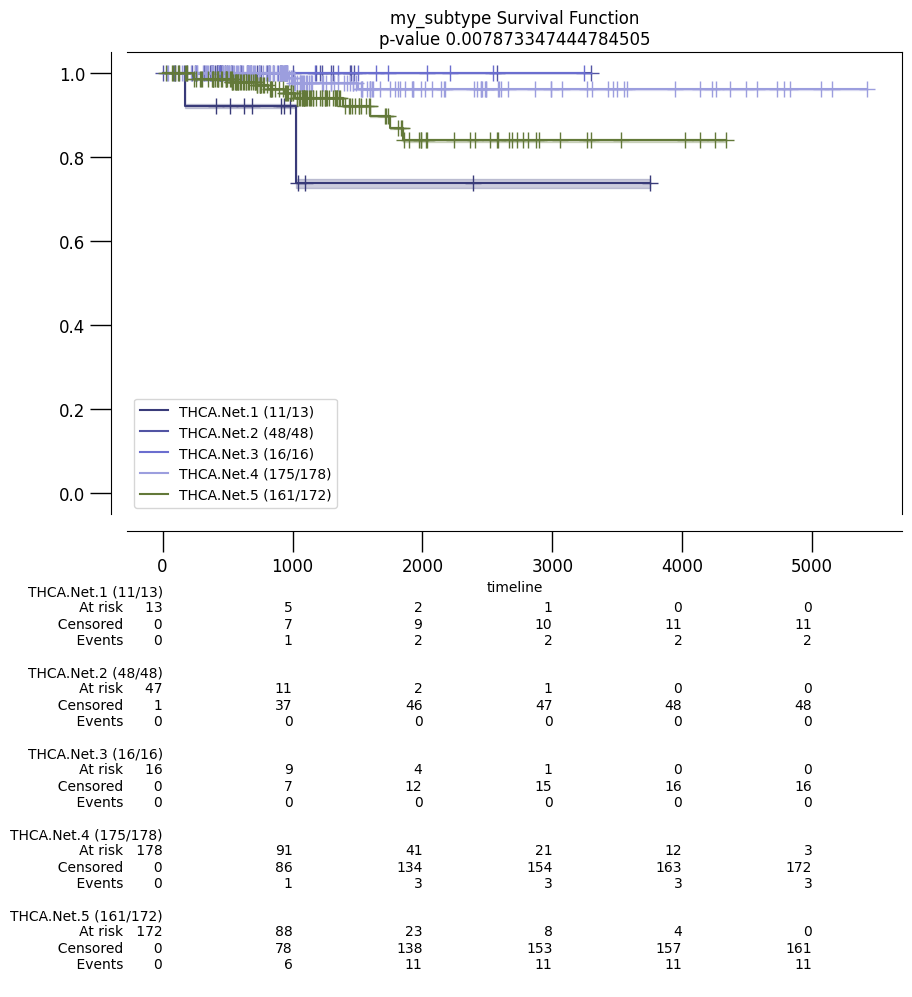

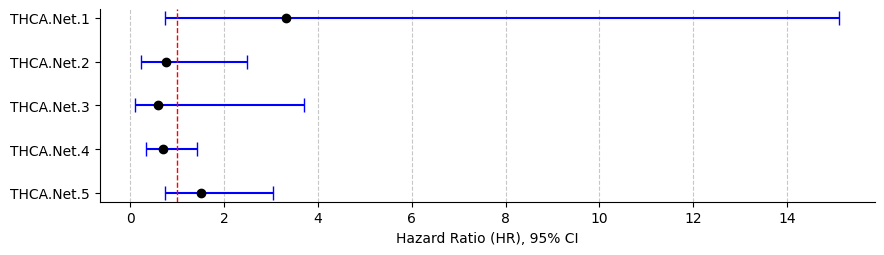

Multivariate log-rank p-value 0.5030832438823081
Subtypes THCA.3 and THCA.4  are the most stratified, with a minimum pairwise p-value of 0.14546404120746814


<lifelines.CoxPHFitter: fitted with 427 total observations, 411 right-censored observations>
             duration col = 'time'
                event col = 'died'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 427
number of events observed = 16
   partial log-likelihood = -84.02
         time fit was run = 2025-02-03 19:33:13 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
Subtype_Selected_THCA.1  0.20      1.22      0.39           -0.56            0.96                0.57                2.61
Subtype_Selected_THCA.2  0.02      1.02      0.49           -0.94            0.98                0.39                2.65
Subtype_Selected_THCA.3 -0.32      0.72      0.47           -1.24            0.59                0.29                1.81
Subtype_Selected_THCA.4  0.23      1.26      0.40           -0.54            1.01                0.58                2.75
Subtype_Selected_THCA.5 -0.23      0.79      0.44           -1.09            0.62                0.34                1.86

                         cmp to     z    p  -log2(p)
covariate                                           
Subtype_Selected_THCA.1    0.00  0.52 0.60      0.73
Subtype_Selected_THCA.2    0.00  0.03 0.97      0.04
Subtype_Selected_THCA.3    0.00 -0.69 0.49      1.03
Subtype_Selected_THCA.4    0.00  0.59 0.55      0.85
Subtype_Selected_THCA.5    0.00 -0.54 0.59      0.76
---
Concordance = 0.67
Partial AIC = 178.05
log-likelihood ratio test = 1.67 on 5 df
-log2(p) of ll-ratio test = 0.16

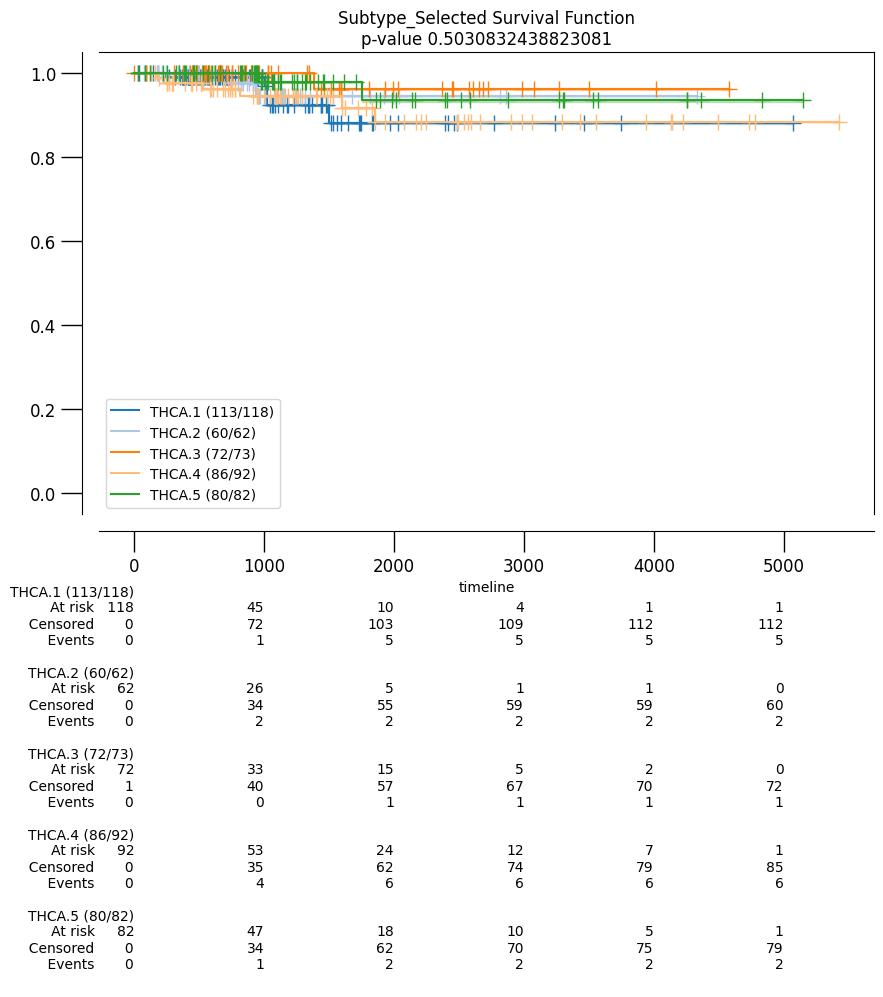

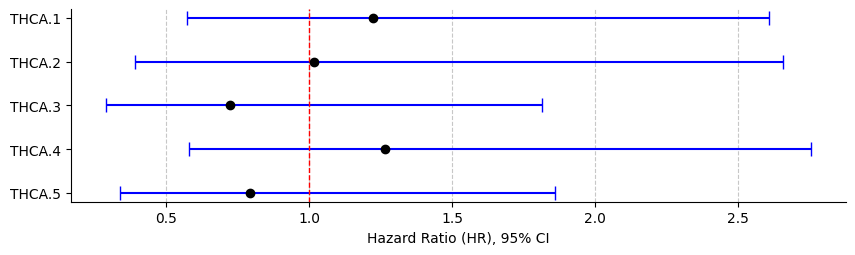

In [34]:
my_filtered_subtypes = my_subtypes[my_subtypes['sample_id'].isin(known_subtypes_df['sample_id'])]
tcga_filtered_subtypes = known_subtypes_df[known_subtypes_df['sample_id'].isin(my_subtypes['sample_id'])]
plot_survival(my_filtered_subtypes, subtype_col='my_subtype', colors='tab20b')
plot_survival(tcga_filtered_subtypes, subtype_col='Subtype_Selected', colors='tab20')